In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier


In [2]:
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
TargetTrain = pd.read_csv('./data/dengue_labels_train.csv' )
FeatureTest = pd.read_csv('./data/dengue_features_test.csv',parse_dates = ['week_start_date'])
Answersheet = pd.read_csv('./data/submission_format.csv' )

### look at target first

In [3]:
"""
This is the difference between two measure

https://journals.ametsoc.org/doi/pdf/10.1175/BAMS-D-14-00226.1


"""

'\nThis is the difference between two measure\n\nhttps://journals.ametsoc.org/doi/pdf/10.1175/BAMS-D-14-00226.1\n\n\n'

In [4]:
panel = TargetTrain.merge(FeatureTrain,on = ['city','year','weekofyear'] ,how = 'outer') 
 
kelvin = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',   'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_dew_point_temp_k']
panel.loc[:,kelvin] = panel.loc[:,kelvin]-273.15# kelvin to C
FeatureTest.loc[:,kelvin] =FeatureTest.loc[:,kelvin]-273.15# kelvin to C
panel.columns

timeid = ['year', 'weekofyear']
green = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
precipitation  =['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',]
 
avg_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',  'station_avg_temp_c' ]
   
min_temp = ['station_min_temp_c','reanalysis_min_air_temp_k']
 
max_temp = ['station_max_temp_c','reanalysis_max_air_temp_k']
 
dtr =  ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
 

humid = ['reanalysis_dew_point_temp_k','reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent']
 
selected = humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green + ['city','total_cases','week_start_date']
features_selected= humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green  
# precipitation_amt_mm  & reanalysis_sat_precip_amt_mm are the same
 
panel = panel.loc[:,selected]
 

In [5]:
panel.columns

Index(['reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
       'station_diur_temp_rng_c', 'station_max_temp_c',
       'reanalysis_max_air_temp_k', 'station_min_temp_c',
       'reanalysis_min_air_temp_k', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'station_avg_temp_c', 'precipitation_amt_mm',
       'reanalysis_sat_precip_amt_mm', 'station_precip_mm',
       'reanalysis_precip_amt_kg_per_m2', 'year', 'weekofyear', 'ndvi_ne',
       'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'city', 'total_cases',
       'week_start_date'],
      dtype='object')

In [6]:
sj = panel.loc[panel.city == 'sj'].interpolate()  .set_index('week_start_date').copy().drop(['city'],axis = 1)
iq = panel.loc[panel.city == 'iq']  .interpolate()  .set_index('week_start_date').copy().iloc[60:].drop(['city'],axis = 1)
 

In [7]:
city_name = 'iq'

iq_test = FeatureTest.loc[FeatureTest.city == city_name].interpolate().set_index('week_start_date').copy().drop('city',axis = 1)
iq_test['total_cases'] = np.nan 

iq = pd.concat([iq,iq_test ],sort = False)
 
train_len = len(iq_test['total_cases'])

 
data_selected = iq.loc[:,['total_cases']] .copy() 
data_candidate = iq .copy().iloc[: ]
data_candidate['green'] = data_candidate.loc[:,green].mean(1)
#data_candidate['green_s'] = data_candidate.loc[:,green[2:]].mean(1)

In [8]:

def de_season_tri(data,target):
    data = data.copy()
    data["season_sin"] = np.sin(data.index.weekofyear/53*6.2831)
    data["season_cos"] = np.cos(data.index.weekofyear/53*6.2831)
    expr = """  ~ """
    expr = target + expr
    
    for name in ["season_sin","season_cos"]:
        expr +=     name  + ' + '
    expr = expr[:-2]
 
    Y , X  = dmatrices(expr, data, return_type='dataframe')
    if target == 'total_cases':
        Y = Y.clip(0,50)
    model = sm.OLS(Y,X)
    results = model.fit()
    
 
 
    
    return  data.loc[:,target] - results .predict(X)  ,results.params

def seasonal_predict(data,params):
    data = data.copy()
    data["season_sin"] = np.sin(data.index.weekofyear/53*6.2831)
    data["season_cos"] = np.cos(data.index.weekofyear/53*6.2831)
    
    expr = """  ~ """
    expr = 'total_cases' + expr
    
    for name in ["season_sin","season_cos"]:
        expr +=     name  + ' + '
    expr = expr[:-2]
   
    Y , X  = dmatrices(expr, data, return_type='dataframe')
    
    return  X.dot(params)
# season _indicatores
residuals,params = de_season_tri(data_candidate,'total_cases')
data_selected['season_based'] = seasonal_predict(data_selected.fillna(0) ,params)

def append_shift(left,right,selected,shift,smooth =52):
    new_names = []
    for name in selected:
        new_name = name + '_shift_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth  ).mean().shift(shift).loc[:,name ]
    return left

def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth  ).mean().diff(diff).loc[:,name ]
    return left

def append_non_season(left,right,selected,shift,smooth = 52):
    new_names = []
    for name in selected:
        new_name = name + '_de_season_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        val,_ = de_season_tri(right,name)
        left[new_name]       = val.rolling(smooth   ).mean().shift(shift)
    return left

def append_product(left,right, selected,shift,smooth = 52):
    new_name = selected[0] + "_X_" + selected[1]
    left[new_name]       = right.loc[:,selected[0] ].multiply (right.loc[:,selected[1] ],axis = 0).rolling(smooth ).mean()
    return left
 
data_selected = append_shift(data_selected,data_candidate,\
      ['reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg',
         'station_max_temp_c','station_min_temp_c', 'station_avg_temp_c'],2,20)

data_selected = append_shift(data_selected,data_candidate,\
      ['precipitation_amt_mm'],2,100)


data_selected =  append_shift(data_selected,data_candidate,\
      [ 'station_min_temp_c',],2,52)

data_selected =  append_diff(data_selected,data_candidate,\
      [ 'reanalysis_relative_humidity_percent','station_min_temp_c'  ],52,20)

 
#data_selected =  append_product(data_selected,data_candidate ,\
#      [  'reanalysis_relative_humidity_percent','station_min_temp_c' ],2,20)
 

data_selected =  append_product(data_selected,data_candidate ,\
      [  'reanalysis_relative_humidity_percent','station_min_temp_c' ],0,20) 



data_selected =  append_product(data_selected,data_candidate ,\
      ['reanalysis_tdtr_k', 'green' ],0,20) 
data_selected =  append_product(data_selected,data_candidate ,\
      ['green', 'green' ],0,10) 
 
#data_selected =  append_product(data_selected,data_candidate ,\
#      ['ndvi_ne', 'ndvi_ne' ],0,10) 

data_selected =  append_product(data_selected,data_candidate ,\
      ['reanalysis_tdtr_k', 'reanalysis_tdtr_k' ],0,20) 

 


data_selected =  append_product(data_selected,data_candidate ,\
      ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2' ],2,10) 


data_selected =  append_product(data_selected,data_candidate ,\
      ['station_max_temp_c', 'station_max_temp_c' ],0,20) 

data_selected =  append_product(data_selected,data_candidate ,\
      ['station_max_temp_c', 'station_min_temp_c' ],0,20) 

data_selected =  append_product(data_selected,data_candidate ,\
      [  'reanalysis_specific_humidity_g_per_kg','station_diur_temp_rng_c' ],0,30) 

 


data_selected =  append_product(data_selected,data_candidate ,\
      [  'station_precip_mm','station_precip_mm' ],0,30) 

data_selected =  append_product(data_selected,data_candidate ,\
      [  'reanalysis_precip_amt_kg_per_m2','ndvi_sw' ],2,10) 


data_selected =  append_product(data_selected,data_candidate ,\
      [  'reanalysis_relative_humidity_percent','station_max_temp_c' ],0,10) 

 

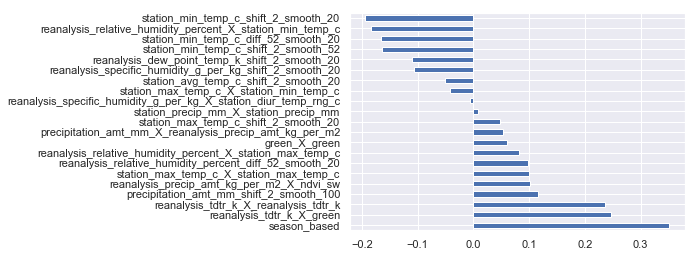

In [9]:
data_selected_corr = data_selected .corr().total_cases.drop([ 'total_cases'])
data_selected_corr  .sort_values(ascending=False) .plot.barh( )

In [10]:
from sklearn.model_selection import KFold
data = data_selected.copy() .iloc[:-train_len ].dropna()
data_test = data_selected.copy().iloc[-train_len: ].fillna(method = 'ffill') .fillna(method = 'bfill').replace(np.nan,0)
kf = KFold(n_splits=4, random_state=None, shuffle=False)

expr = """total_cases ~   -1 + """
drops = ['total_cases','season_based' ]
for name in data.drop(drops,axis = 1).columns:
    expr +=    name + ' + '
expr=  expr[:-2]

maes = []
models = []
test_xs = []
test_ys = []
pred_ys = []
    
for train_index, test_index in kf.split(data):
    
    df_train = data.iloc[train_index,:]
    df_test  = data.iloc[test_index,:]
    
    train_y,  train_X = dmatrices(expr, df_train, return_type='dataframe')
    test_y,  test_X = dmatrices(expr, df_test, return_type='dataframe')
    
    test_xs.append(test_X)
    test_ys.append(test_y)
    
    model = RandomForestRegressor(n_estimators=400, max_depth=6,min_samples_split = 8,min_samples_leaf =32,
                                             criterion='mae', warm_start=True)
    train_y = (train_y.iloc[:,0] .clip(0,80).rolling(3,center = True).mean()) .dropna()
    train_X = train_X.loc[train_y.index]
    model.fit( train_X,train_y   )
    pred_res = model.predict(test_X )
    pred_res = pd.Series(pred_res,index =df_test.index )
    pred_ys.append(pred_res)
    models.append(model)
    maes .append(abs(test_y.values.ravel()- pred_res.values.ravel()).mean())
    
 

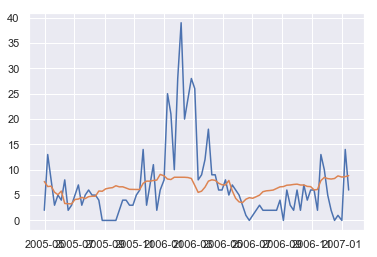

In [11]:
ith =1
plt.plot(  test_ys[ith] )
plt.plot(pd.Series(models[ith].predict(test_xs[ith] ),index = test_ys[ith].index)   )
 
test = pd.concat(test_ys) 
validate =pd.DataFrame( pd.concat(pred_ys)) 

ensamble_samples = validate.merge(test,left_index= True,right_index = True )
ensamble_samples.to_csv('./data/ensamble_rf_' +str(city_name) + '.csv')

In [12]:
np.mean(maes)

6.40090701727008

In [13]:
m1  = pd.Series(models[0].feature_importances_,index= train_X.columns).sort_values().iloc[-60:]
m2  = pd.Series(models[1].feature_importances_,index= train_X.columns).sort_values().iloc[-60:] 
m3  = pd.Series(models[2].feature_importances_,index= train_X.columns).sort_values().iloc[-60:]
m4  = pd.Series(models[3].feature_importances_,index= train_X.columns).sort_values().iloc[-60:]

In [14]:
df_total  = data 
    
total_y,  total_X = dmatrices(expr, df_total, return_type='dataframe')
model = RandomForestRegressor(n_estimators=400, max_depth=6,min_samples_split = 8,min_samples_leaf =32,
                                         criterion='mae', warm_start=True)
model.fit( total_X ,total_y.iloc[:,0].clip(0,70))


 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=32,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=True)

In [15]:
 
submit_y,  submit_X = dmatrices(expr, data_test , return_type='dataframe')

pd.Series(np.round(model.predict(submit_X)).astype(int),index = submit_y.index).\
to_csv("./data/0127_rf_" + str(city_name) + ".csv",header = False)

### Based model